<a href="https://colab.research.google.com/github/JavadZandiyeh/AUT-DIP-Projects/blob/main/DIP_HW3_9831032.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title RUN THIS BLOCK WITHOUT ANY CHANGE to download the data
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1ywJuPPm-NWkSfHMvB6xN7Y08S7H3L7Vl' -O 'DIP_HW3_data.zip'
!unzip DIP_HW3_data.zip

--2023-12-24 08:10:22--  https://drive.google.com/uc?export=download&id=1ywJuPPm-NWkSfHMvB6xN7Y08S7H3L7Vl
Resolving drive.google.com (drive.google.com)... 142.250.99.101, 142.250.99.139, 142.250.99.138, ...
Connecting to drive.google.com (drive.google.com)|142.250.99.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0r0r5f7027i7pcejnq14hg95k2k9ljp6/1703405400000/14300142125693899780/*/1ywJuPPm-NWkSfHMvB6xN7Y08S7H3L7Vl?e=download&uuid=ab0cda75-5957-4a57-a96d-29a44db16ece [following]
--2023-12-24 08:10:23--  https://doc-00-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0r0r5f7027i7pcejnq14hg95k2k9ljp6/1703405400000/14300142125693899780/*/1ywJuPPm-NWkSfHMvB6xN7Y08S7H3L7Vl?e=download&uuid=ab0cda75-5957-4a57-a96d-29a44db16ece
Resolving doc-00-1g-docs.googleusercontent.com (doc-00-1g-docs.googleusercontent.com)... 74.125.20.132, 2607:f

# Imports



In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math

# Any Helper Functions


In [ ]:
def image_show1(ax, image, title, vmin=0, vmax=255, cmap='gray'):
    ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.axis('off') # Hide axis labels
    ax.set_title(title, color='white', backgroundcolor='green')

def image_show2(image, title, vmin=0, vmax=255, cmap='gray', figsize=(6, 4)):
    plt.figure(figsize=figsize) # Set figure size
    plt.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis('off') # Hide axis labels
    plt.title(title, color='white', backgroundcolor='green') # Set title
    plt.show()

def hist_show(image, title):
    hist, bins = np.histogram(image.flatten(), bins=64, range=[0, 255])
    plt.bar(bins[:-1], hist, width=0.5, align='edge', color='black')
    plt.title(title, color='white', backgroundcolor='green')

# Question 3: Image Restoration (35%)

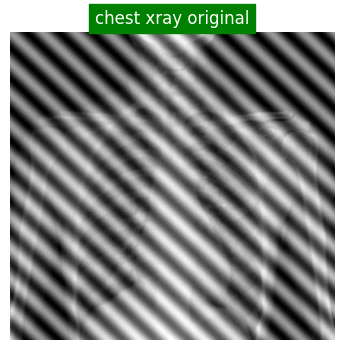

In [ ]:
#@title Q3 - Part 1 (5%)
image1 = cv2.imread('chest_xray.png', cv2.IMREAD_GRAYSCALE)

image_show2(image1, 'chest xray original')

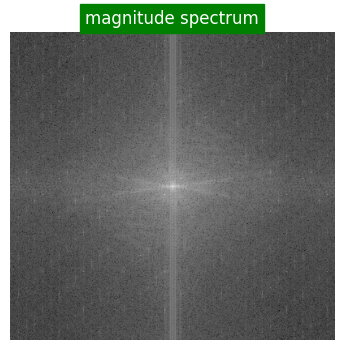

In [ ]:
#@title Q3 - Part 2 (10%)

# Perform 2D fourier transform
F = np.fft.fft2(image1)
# Shift zero frequency components to the center
Fshift = np.fft.fftshift(F)

# Compute magnitude spectrum
magnitude_spectrum = 15 * np.log(np.abs(Fshift) + 1)

image_show2(magnitude_spectrum, 'magnitude spectrum')

spike positions: (array([190, 180, 200, 190]), array([199, 210, 190, 200]))


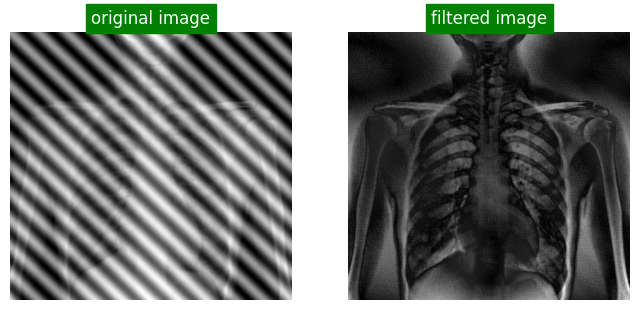

In [ ]:
#@title Q3 - Part 3 (30%)

## Findout position of spikes
# 1. Get the indices of the array in sorted order
sorted_indices = np.argsort(magnitude_spectrum, axis=None)
# 2. Take the last indices (here 4)
highest_indices = sorted_indices[-4:]
# 3. Convert the flattened indices to 2D coordinates
highest_positions = np.unravel_index(highest_indices, magnitude_spectrum.shape)
print(f'spike positions: {highest_positions}')

## Notch reject filter
def notch_reject_filter(shape, points, d0=9):
    m, n = shape # Shape of filter
    num_points = len(points[0]) # Number of spikes in filter
    H = np.ones((m, n)) # Initialize filter with zeros

    for u in range(m):
        for v in range(n):
            for d in range(num_points):
                u0 = points[0][d]
                v0 = points[1][d]
                d1 = pow(u - u0, 2) + pow(v - v0, 2)
                d2 = pow(u + u0, 2) + pow(v + v0, 2)
                if d1 <= d0 or d2 <= d0:
                    H[u][v] *= 0

    return H

notch_filter = notch_reject_filter(magnitude_spectrum.shape, highest_positions, 4)

# Performe notch filter to remove noises
Gshift = Fshift * notch_filter

# Inverse fourier transform
G = np.fft.ifftshift(Gshift)
g = np.abs(np.fft.ifft2(G))

# re-normalize to 8-bits
min, max = np.amin(g, (0,1)), np.amax(g, (0,1))
g = cv2.normalize(g, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


fig, ax = plt.subplots(1, 2, figsize=(8, 4))
image_show1(ax[0], image1, 'original image')
image_show1(ax[1], g, 'filtered image')

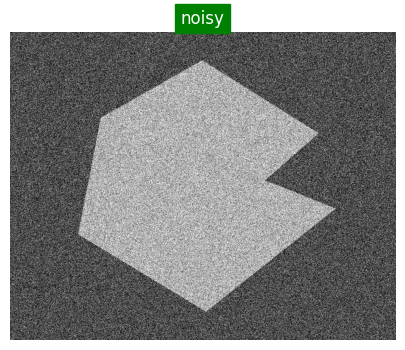

In [ ]:
#@title Q3 - Part 4 (5%)
image2 = cv2.imread('noisy.png', cv2.IMREAD_GRAYSCALE)

image_show2(image2, 'noisy')

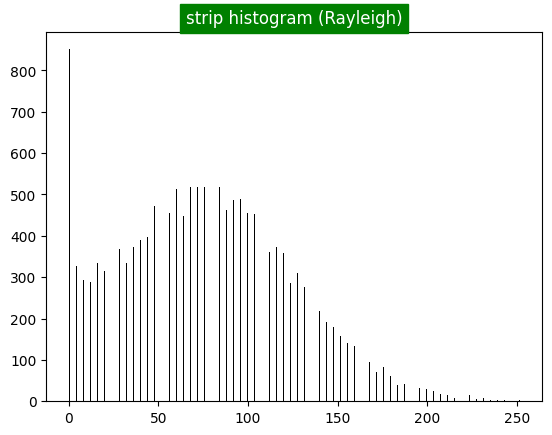

In [ ]:
#@title Q3 - Part 5 (15%)
m, n = image2.shape

strip = image2[:math.floor(m/2), :50]

hist_show(strip, 'strip histogram (Rayleigh)') # Rayleigh noise

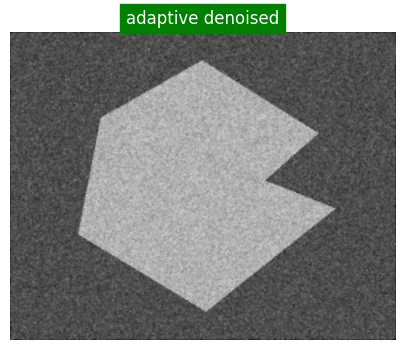

In [ ]:
#@title Q3 - Part 6 (15%)

# Base values
m, n = image2.shape
kernel_size = (5, 5)

# Define the amount of padding for each dimension
# 1. Keep the size of the matrix equivalent to that of image2 after obtaining the local_mean and local_variance.
pad_row = math.floor(kernel_size[0] / 2)
pad_col = math.floor(kernel_size[1] / 2)
# 2. Create padding window
pad_width = ((pad_row, pad_row), (pad_col, pad_col))  # ((before_row, after_row), (before_col, after_col))
# 3. Get padded image
f = np.pad(image2, pad_width, mode='constant', constant_values=0)

# Initialize matrices
noise_var = np.var(strip)
local_mean = np.zeros_like(image2, dtype=float)
local_var = np.zeros_like(image2, dtype=float)

# Set values for matrices
for u in range(m):
    for v in range(n):
        window = f[u : u + kernel_size[0], v : v + kernel_size[1]]
        local_mean[u][v] = np.mean(window)
        local_var[u][v] = np.var(window)

# Compute denoised image
f_adaptive = image2 - (noise_var / local_var) * (image2 - local_mean)

# Show adaptive denoised image
image_show2(f_adaptive, 'adaptive denoised')

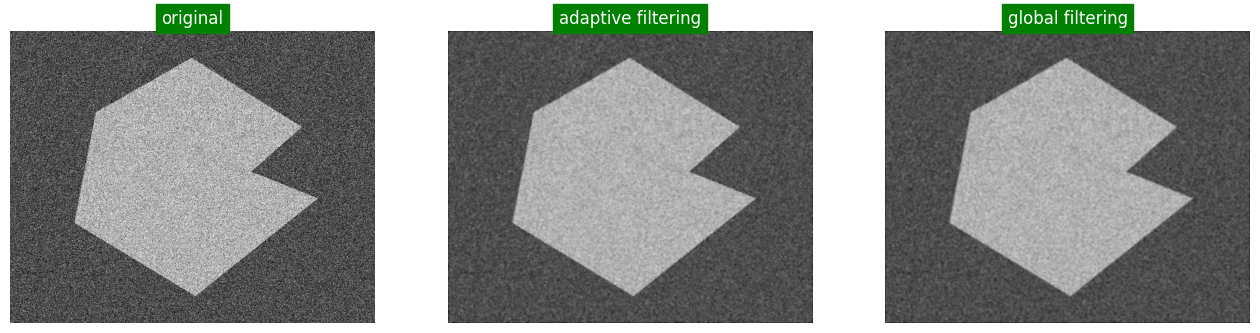

In [ ]:
#@title Q3 - Part 7 (10%)
f_global = np.zeros_like(image2)
kernel_size = (5, 5)

for u in range(m):
    for v in range(n):
        window = f[u : u + kernel_size[0], v : v + kernel_size[1]]
        f_global[u][v] = np.mean(window)

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
image_show1(ax[0], image2, 'original')
image_show1(ax[1], f_adaptive, 'adaptive filtering')
image_show1(ax[2], f_global, 'global filtering')

<div dir=rtl><font color='green' size="5">جواب سوال ۳-۸</font>
<div>

<div dir=rtl><font size="4">
در روش Adaptive Filtering در جایی که جزئیات تصویر بیشتر بوده است، به تصویر اهمیت داده است و نه به نویز. در حالیکه زمانی که واریانس نویز و واریانس پیکسل‌های یک ناحیه حدودا برابر باشد همان عمل میانگین گیری را انجام میدهد. در این دو شکل سمت راست، میتوان دید که در قسمت داخلی شکل، نویز گیری در حالت Adaptive بهتر از حالت Mean است و همینطور در مرزهای بین سیاه و سفید
 </font><br />
</div>

# Question 4: Morphology (35%)

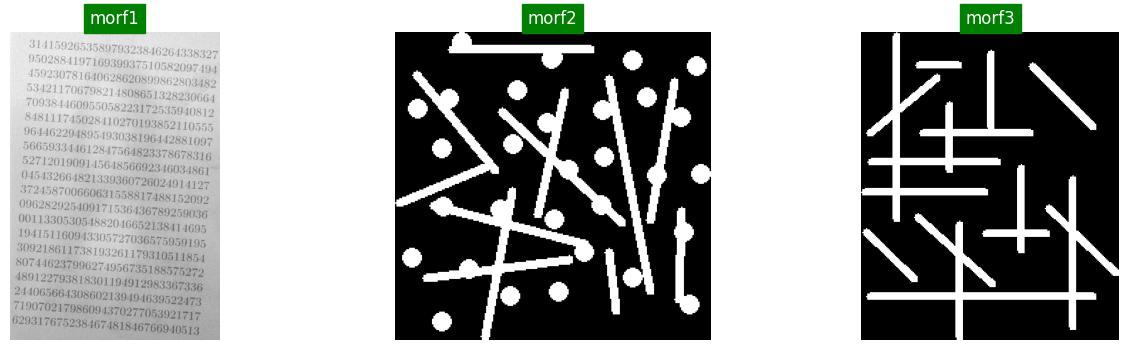

In [ ]:
#@title Q4 - Part 1 (5%)
morf1 = cv2.imread('morf1.png', cv2.IMREAD_GRAYSCALE)
morf2 = cv2.imread('morf2.png', cv2.IMREAD_GRAYSCALE)
morf3 = cv2.imread('morf3.png', cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
image_show1(ax[0], morf1, 'morf1')
image_show1(ax[1], morf2, 'morf2')
image_show1(ax[2], morf3, 'morf3')

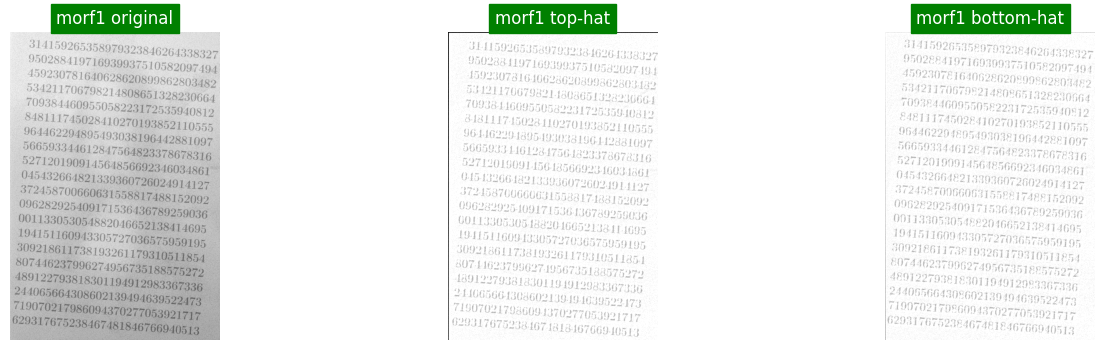

In [ ]:
#@title Q4 - Part 2 (35%)

# Define a kernel for morphological operations
kernel = np.zeros((5, 5), np.uint8)

# Opening of morf1 and kernel (background for top-hat)
morf1_open_kernel = cv2.morphologyEx(morf1, cv2.MORPH_OPEN, kernel)

# Closing of morf1 and kernel (background for bottom-hat)
morf1_close_kernel = cv2.morphologyEx(morf1, cv2.MORPH_CLOSE, kernel)

# Findout Top-hat and Bottom-hat
T_hat_morf1 = morf1 - morf1_open_kernel
B_hat_morf1 = morf1_close_kernel - morf1

# Another way to findout Top-hat and Bottom-hat
T_hat_morf1 = cv2.morphologyEx(morf1, cv2.MORPH_TOPHAT, kernel)
B_hat_morf1 = cv2.morphologyEx(morf1, cv2.MORPH_BLACKHAT, kernel)

# Show images
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
image_show1(ax[0], morf1, 'morf1 original')
image_show1(ax[1], 256 - T_hat_morf1, 'morf1 top-hat')
image_show1(ax[2], 256 - B_hat_morf1, 'morf1 bottom-hat')

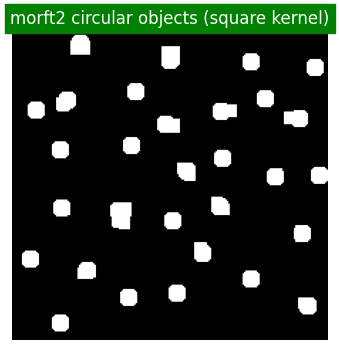

In [ ]:
#@title Q4 - Part 3 (20%)
kernel = np.ones((8, 8), np.uint8)

morf2_open_kernel = cv2.morphologyEx(morf2, cv2.MORPH_OPEN, kernel)

image_show2(morf2_open_kernel, 'morft2 circular objects (square kernel)')

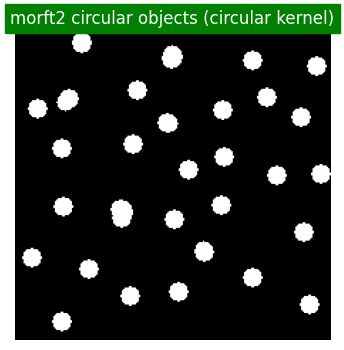

In [ ]:
#@title Q4 - Part 4 (10%)
def circular_kernel(radius):
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    kernel = np.zeros((2*radius+1, 2*radius+1), np.uint8)
    kernel[mask] = 1
    return kernel

kernel = circular_kernel(6)

morf2_open_kernel = cv2.morphologyEx(morf2, cv2.MORPH_OPEN, kernel)

image_show2(morf2_open_kernel, 'morft2 circular objects (circular kernel)')

<div dir=rtl><font color='green' size="5">## توضیحات سوال ۴-۴</font>
<div>

<div dir=rtl><font size="4">
از کرنل دایره ای شکل استفاده میکنیم که ظاهر دایره ها به مربع تغییر پیدا نکنند. زیرا در حالت قبل، علاوه بر اینکه به خوبی دایره ها استخراج نشده بودند، شکل آنها به مربع تغییر یافته بود
 </font><br />
</div>

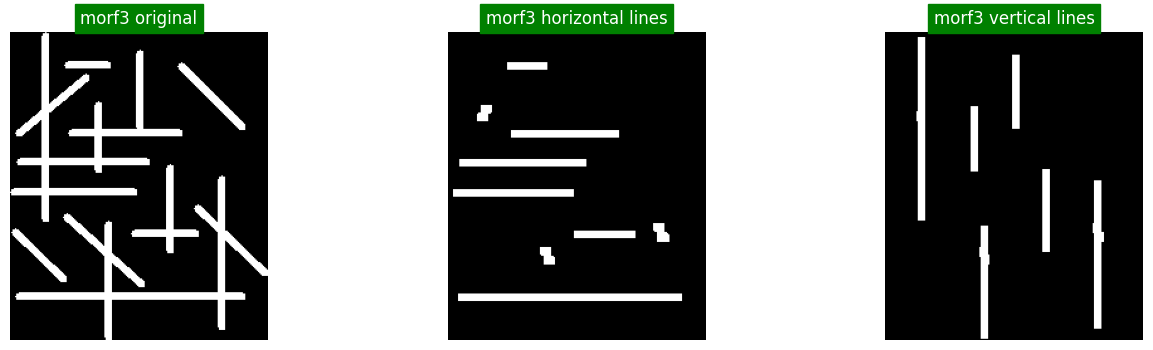

In [ ]:
#@title Q4 - Part 5 (20%)
# Horizontal kernel
h_kernel = np.ones((6, 8), np.uint8)
pad = np.zeros((2, 8), np.uint8)
h_kernel = np.vstack((h_kernel, pad))
h_kernel = np.vstack((pad, h_kernel))

morf3_open_h_kernel = cv2.morphologyEx(morf3, cv2.MORPH_OPEN, h_kernel)

# Vertical kernel
v_kernel = np.ones((8, 6), np.uint8)
pad = np.zeros((8, 2), np.uint8)
v_kernel = np.hstack((v_kernel, pad))
v_kernel = np.hstack((pad, v_kernel))

morf3_open_v_kernel = cv2.morphologyEx(morf3, cv2.MORPH_OPEN, v_kernel)

# Show images
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
image_show1(ax[0], morf3, 'morf3 original')
image_show1(ax[1], morf3_open_h_kernel, 'morf3 horizontal lines')
image_show1(ax[2], morf3_open_v_kernel, 'morf3 vertical lines')

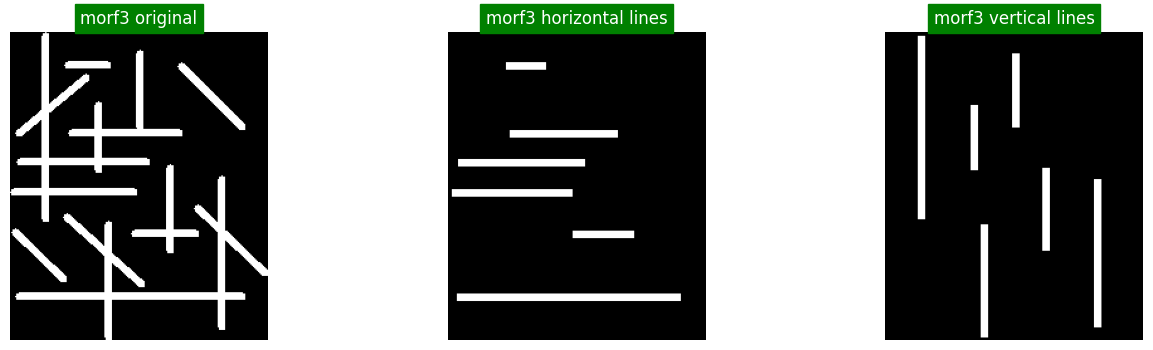

In [ ]:
#@title Q4 - Part 6 (10%)
# Horizontal kernel
h_kernel = np.ones((6, 15), np.uint8)
pad = np.zeros((2, 15), np.uint8)
h_kernel = np.vstack((h_kernel, pad))
h_kernel = np.vstack((pad, h_kernel))

morf3_open_h_kernel = cv2.morphologyEx(morf3, cv2.MORPH_OPEN, h_kernel)

# Vertical kernel
v_kernel = np.ones((15, 6), np.uint8)
pad = np.zeros((15, 2), np.uint8)
v_kernel = np.hstack((v_kernel, pad))
v_kernel = np.hstack((pad, v_kernel))

morf3_open_v_kernel = cv2.morphologyEx(morf3, cv2.MORPH_OPEN, v_kernel)

# Show images
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
image_show1(ax[0], morf3, 'morf3 original')
image_show1(ax[1], morf3_open_h_kernel, 'morf3 horizontal lines')
image_show1(ax[2], morf3_open_v_kernel, 'morf3 vertical lines')

<div dir=rtl>
<font color='green' size="5">## توضیحات سوال  ۴-۶</font>
<div>
<font size="4">
اندازه کرنل را از اندازه محل برخورد خطوط بزرگتر میکنیم که در هنگام عملیت opening این موارد حذف شوند. یعنی کرنل را طولانی تر میکنیم. به عنوان مثال طول آنرا از ۶ به ۱۵ تغییر داده ایم در این حالت
 </font><br />
</div>